In [12]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

## Import Libraries

In [13]:
import numpy as np
import os, requests
from matplotlib import pyplot as plt

## Import plot functions and define parameters

In [14]:
# import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Load data

In [15]:
# Load Data
fname = []
for j in range(3):
    fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
    if not os.path.isfile(fname[j]):
        try:
            r = requests.get(url[j])
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
        else:        
            if r.status_code != requests.codes.ok:
                print("!!! Failed to download data !!!")
            else:
                with open(fname[j], "wb") as fid:
                    fid.write(r.content)

In [16]:
# Data loading
alldat = np.array([])
for j in range(len(fname)):
    alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


## Group brain regions

In [17]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

nareas = 4 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
    barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region

## Plot: mean neural activity vs response

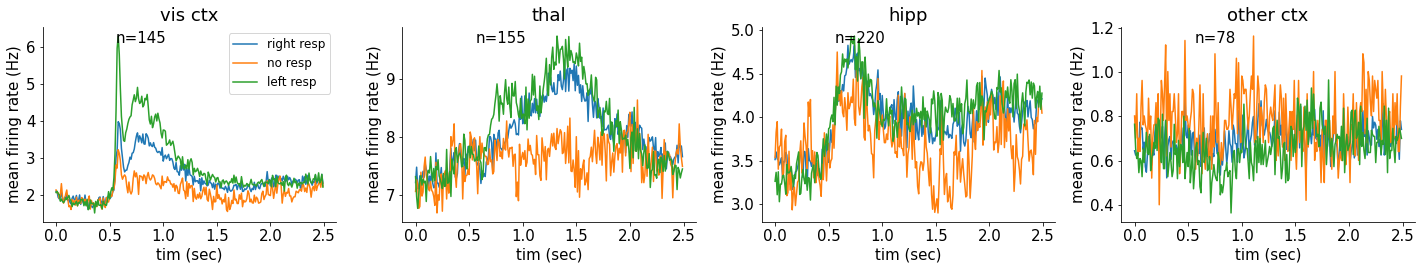

In [18]:
# plots by brain region and responses
response = dat['response'] # right - nogo - left (-1, 0, 1)
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

for j in range(nareas):
    ax = plt.subplot(1,nareas,j+1)
  
    plt.plot(dt * np.arange(NT), 1/dt *  dat['spks'][barea==j][:,response>=0].mean(axis=(0,1)))
    plt.plot(dt * np.arange(NT), 1/dt *  dat['spks'][barea==j][:,response==0].mean(axis=(0,1)))
    plt.plot(dt * np.arange(NT), 1/dt *  dat['spks'][barea==j][:,response<0].mean(axis=(0,1)))  
    plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)

    if j==0:
        plt.legend(['right resp','no resp', 'left resp'], fontsize=12)
    ax.set(xlabel = 'tim (sec)', ylabel = 'mean firing rate (Hz)', title = regions[j])

hide_toggle()

## Plot: mean neural activity vs task difficulty

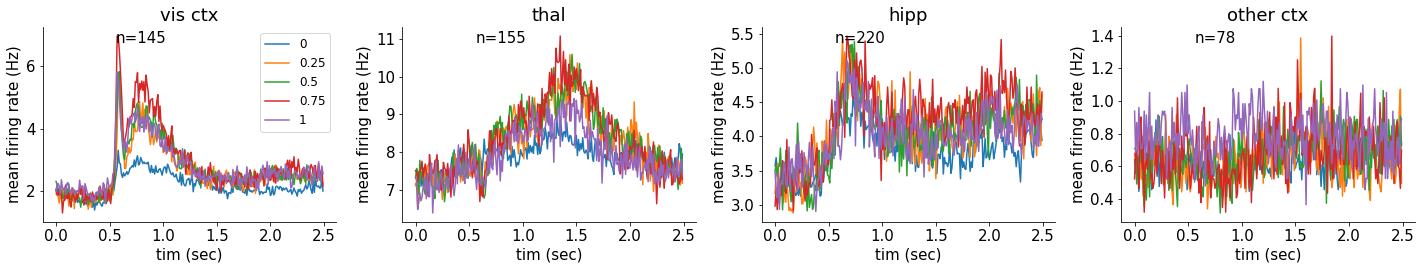

In [19]:
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

l_cont = dat['contrast_left']
r_cont = dat['contrast_right']

for j in range(nareas):
    ax = plt.subplot(1,nareas,j+1)
    
    plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0][barea==j].mean(axis=(0,1))) # difference 0
    plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0.25][barea==j].mean(axis=(0,1))) # difference 0.25
    plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0.5][barea==j].mean(axis=(0,1))) # difference 0.5
    plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0.75][barea==j].mean(axis=(0,1))) # difference 0.75
    plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==1][barea==j].mean(axis=(0,1))) # difference 1
  
    plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)

    if j==0:
        plt.legend(['0', '0.25', '0.5', '0.75', '1'], fontsize=12)
    ax.set(xlabel = 'tim (sec)', ylabel = 'mean firing rate (Hz)', title = regions[j])

hide_toggle()

## Pupil area 

[Text(0, 0.5, 'pupil area'),
 Text(0.5, 0, 'binned time'),
 Text(0.5, 1.0, 'Pupil dynamics')]

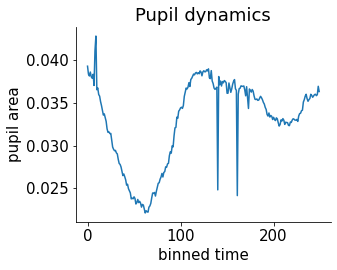

In [25]:
# plot the behavioral data (pupil area is noisy because it's very small)
ax = plt.subplot(1,5,1)
plt.plot(dat['pupil'][0, :].mean(0));
ax.set(ylabel='pupil area', xlabel = 'binned time', title='Pupil dynamics')

In [23]:
dat['pupil'].shape # (3, 340, 250) - (area/horizontal position/vertical position), #trial, time bin

(3, 340, 250)

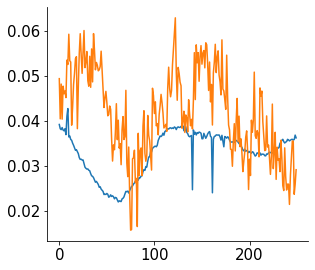

In [57]:
ax = plt.subplot(1,5,1)
plt.plot(dat['pupil'][0, :].mean(0)); # mean pupil area
plt.plot(dat['pupil'][0, 150,:]);     # individual trial 

## Average pupil area vs task difficulty

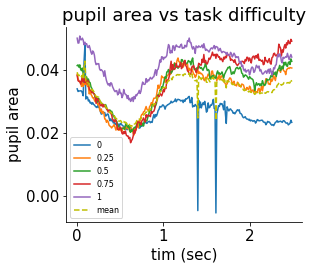

In [55]:
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

l_cont = dat['contrast_left']
r_cont = dat['contrast_right']

ax = plt.subplot(1,5,1)

plt.plot(dt * np.arange(NT), dat['pupil'][:,np.abs(l_cont-r_cont)==0][0,:,:].mean(axis=0))    # difference 0
plt.plot(dt * np.arange(NT), dat['pupil'][:,np.abs(l_cont-r_cont)==0.25][0,:,:].mean(axis=0)) # difference 0.25
plt.plot(dt * np.arange(NT), dat['pupil'][:,np.abs(l_cont-r_cont)==0.5][0,:,:].mean(axis=0))  # difference 0.5
plt.plot(dt * np.arange(NT), dat['pupil'][:,np.abs(l_cont-r_cont)==0.75][0,:,:].mean(axis=0)) # difference 0.75
plt.plot(dt * np.arange(NT), dat['pupil'][:,np.abs(l_cont-r_cont)==1][0,:,:].mean(axis=0))    # difference 1

plt.plot(dt* np.arange(NT), dat['pupil'][0, :].mean(0), 'y--');

plt.legend(['0', '0.25', '0.5', '0.75', '1', 'mean'], fontsize=8)
ax.set(xlabel = 'tim (sec)', ylabel = 'pupil area', title = 'pupil area vs task difficulty')

hide_toggle()